In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os.path
import datetime

In [2]:
extracted_information = pd.read_pickle(os.path.join('..','Extracted_Information_Sectors_Education_Other.dat'))
# select the Education entries and drop values without a valid currency or loan amound
education_with_valid_info = extracted_information.loc[(extracted_information['Project_Sector']=='Education')].dropna(subset=['Currency','Amount_loan'])
print(len(education_with_valid_info))
education_with_valid_info.head()

157


,filename,Date,Project_name,Currency,Amount_loan,Project_Sector
9,1990_august_13_930351468250521631_conformed-co...,1990-08-13 00:00:00,technician education project,$,25000000,Education
25,1990_february_12_603871468052164505_conformed-...,1990-02-12 00:00:00,second secondary education and management project,$,154200000,Education
62,1990_july_9_673731468058475489_conformed-copy-...,1990-07-09 00:00:00,second elementary education project,$,200000000,Education
93,1990_may_18_631461468313480210_conformed-copy-...,1990-05-18 00:00:00,national education development project,$,90200000,Education
95,1990_may_1_670561468035072614_india--technical...,1990-05-01 00:00:00,technician education project,$,25000000,Education


In [3]:
# Now how many currencies are we left with?
education_with_valid_info.Currency.value_counts()

$      140
eur      6
usd      6
€        2
e        1
dem      1
c        1
Name: Currency, dtype: int64

In [4]:
# Some currency conversion could happen later, but there's not enough info for a first-pass to matter.
# So we'll filter on USD.
education_usd = education_with_valid_info.loc[(education_with_valid_info['Currency']=='$') | (education_with_valid_info['Currency']=='usd')]
print(len(education_usd))
education_usd.head()

146


,filename,Date,Project_name,Currency,Amount_loan,Project_Sector
9,1990_august_13_930351468250521631_conformed-co...,1990-08-13 00:00:00,technician education project,$,25000000,Education
25,1990_february_12_603871468052164505_conformed-...,1990-02-12 00:00:00,second secondary education and management project,$,154200000,Education
62,1990_july_9_673731468058475489_conformed-copy-...,1990-07-09 00:00:00,second elementary education project,$,200000000,Education
93,1990_may_18_631461468313480210_conformed-copy-...,1990-05-18 00:00:00,national education development project,$,90200000,Education
95,1990_may_1_670561468035072614_india--technical...,1990-05-01 00:00:00,technician education project,$,25000000,Education


/usr/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


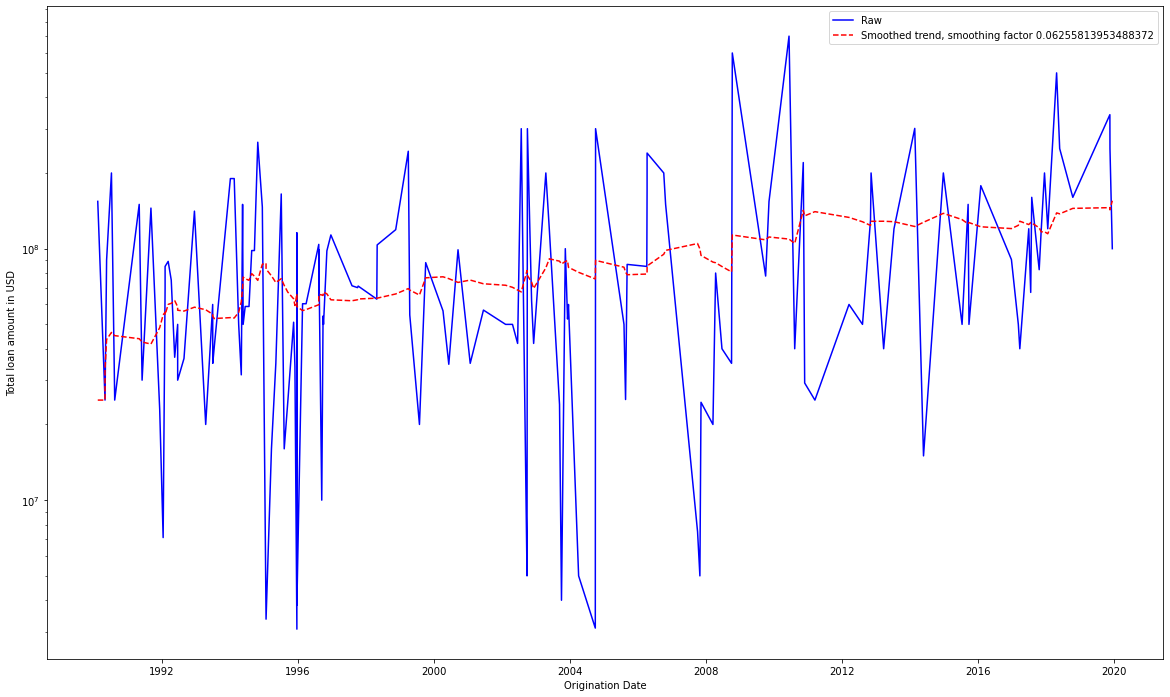

In [5]:
# Multiple entries have the same day so we'll aggregate them
education_aggregated = education_usd[['Date','Amount_loan']].sort_values('Date',axis=0)
education_aggregated.head()

# then we'll fit a trend-curve with some smoothing
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(education_usd['Amount_loan'].values)
smoothed_fit = ses.fit()

plt.figure(figsize=(20,12))
plt.plot(education_aggregated['Date'],education_aggregated['Amount_loan'],'b-',label="Raw")

plt.plot(education_aggregated['Date'],smoothed_fit.fittedvalues,'r--',label="Smoothed trend, smoothing factor "+str(smoothed_fit.params['smoothing_level']))

plt.xlabel('Origination Date')
plt.ylabel('Total loan amount in USD')
plt.yscale('log')
plt.legend()
to_save = plt.gcf()
plt.show()

In [6]:
to_save.savefig('education_usd.svg')

As for education as a percentage of total, we'll group by year as a proof-of-concept.

<ipython-input-52-c8a1151b947a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_valid['year'] = extracted_valid['Date'].apply(lambda x: x.year)


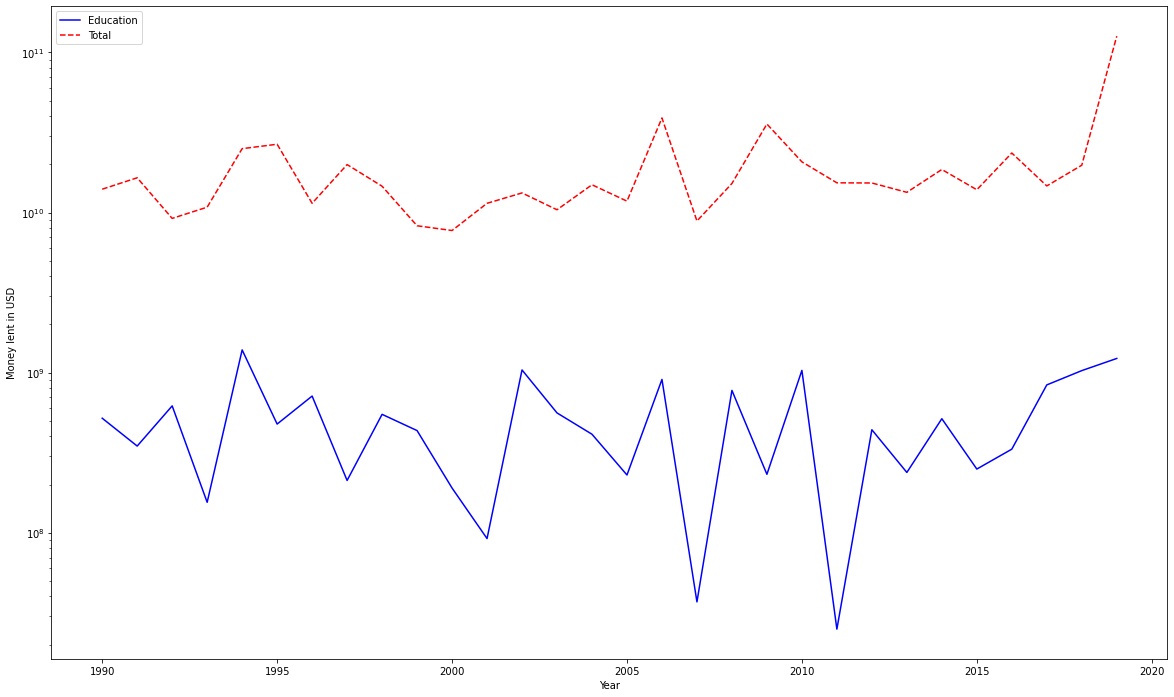

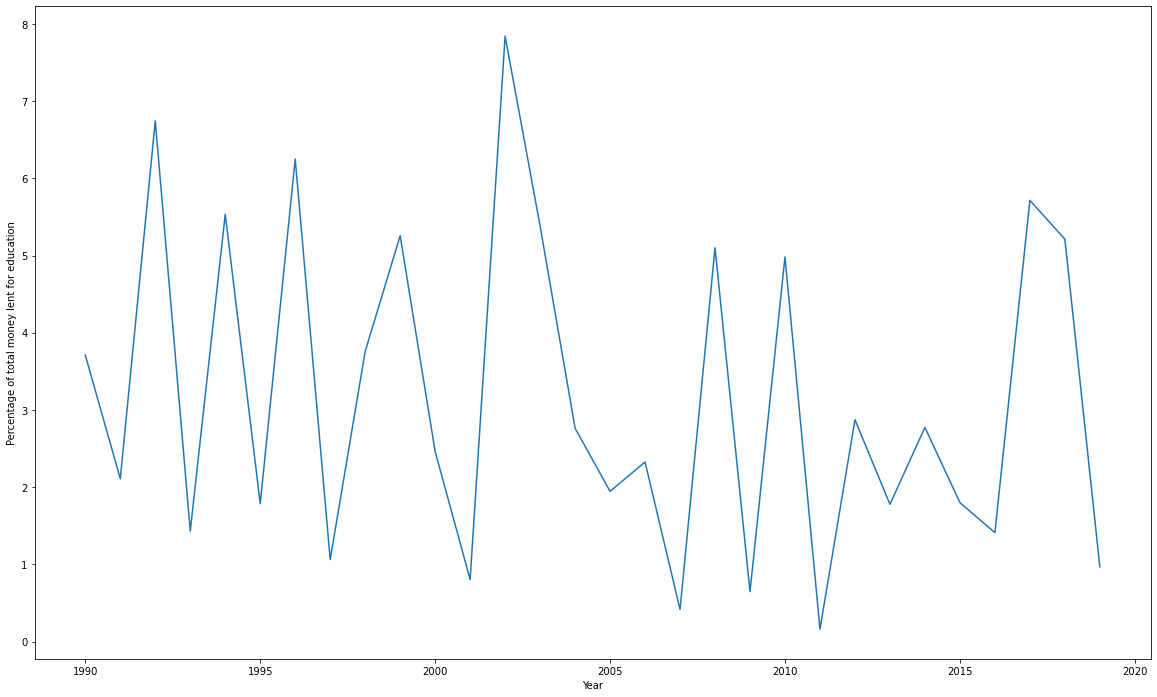

In [52]:
extracted_valid = extracted_information.dropna(subset=['Currency','Amount_loan'])
extracted_valid['year'] = extracted_valid['Date'].apply(lambda x: x.year)
extracted_valid_usd = extracted_valid.loc[(extracted_valid['Currency']=='$') | (extracted_valid['Currency']=='usd')]
education_by_year = extracted_valid[extracted_valid['Project_Sector']=='Education'].groupby('year')['Amount_loan'].sum()
total_by_year = extracted_valid.groupby('year')['Amount_loan'].sum()


plt.figure(figsize=(20,12))
plt.plot(education_by_year.index,education_by_year.values,'b-',label="Education")

plt.plot(total_by_year.index,total_by_year.values,'r--',label="Total")

plt.xlabel('Year')
plt.ylabel('Money lent in USD')
plt.yscale('log')
plt.legend()
ed_vs_total = plt.gcf()
plt.show()

# as percentage of total
pct = education_by_year / total_by_year * 100

plt.figure(figsize=(20,12))
plt.plot(pct.index,pct.values)

plt.xlabel('Year')
plt.ylabel('Percentage of total money lent for education')
pct_ed = plt.gcf()
plt.show()

In [53]:
ed_vs_total.savefig('education_vs_total.svg')
pct_ed.savefig('education_as_percentage.svg')